In [1]:
# Mount the Drive to access the google Drive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#Setting the Tensorflow Version
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
# Installing the KERAS Specific version 2.0.8
!pip install -q keras===2.0.8

In [4]:
#checking the current version of TensorFlow and KERAS
import tensorflow
import keras

print(tensorflow.__version__)
print(keras.__version__)

Using TensorFlow backend.


1.15.2
2.0.8


In [5]:
# Installing the PYDICOM Package to use it for reading the Dicom Images later
!pip install pydicom

In [0]:
#installing the MaskRCNN 
#!pip install mrcnn

In [0]:
#Importing the Required Packages
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import io
import os
import pathlib
import glob
import time

In [8]:
#Setting the Project Root  Directory
!pwd
%cd /content/gdrive/My Drive/Cap-project
PROJ_PATH='/content/gdrive/My\ Drive/Cap-project'
print("path -Working Directory is ",PROJ_PATH)
!dir $PROJ_PATH

/content
/content/gdrive/My Drive/Cap-project
path -Working Directory is  /content/gdrive/My\ Drive/Cap-project
AIML-\ Capstone\ Overview.pdf
Capstone_Project_MaskRCNN_Predict_V5_1_Balaji.ipynb
Capstone_Project_MaskRCNN_Predict_V5_Coco_10000.ipynb
Capstone_Project_MaskRCNN_Predict_V5_Coco_25000.ipynb
Capstone_Project_MaskRCNN_Predict_V5_Trained_250000.ipynb
Capstone\ Schedule.pdf
data
Final\ Report\ Format.pdf
Interim\ Report\ Format.pdf
logs
Mask_RCNN
mask_rcnn_coco.h5
Project\ -\ CV\ -\ Pneumonia\ Detection\ Challenge\ Brief.pdf
sample_submission.csv


In [0]:
# To Get the Coco Weights File one time
#!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [0]:
# Setting the Project Dir/DATA Dir/Out file directory in the project
PROJ_DIR = "/content/gdrive/My Drive/Cap-project"
DATA_DIR = os.path.abspath(PROJ_DIR +'/data')
OUT_DIR = os.path.abspath(PROJ_DIR +'/out')
COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

# Directory to save logs and trained model
MODEL_DIR = os.path.join(PROJ_DIR, 'logs')

if not os.path.exists(PROJ_DIR):
    os.makedirs(PROJ_DIR)
os.chdir(PROJ_DIR)

In [11]:
# Trying to get the Mask RCNN Github to Local Directory
os.chdir(PROJ_DIR)
!git clone https://github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
!python setup.py -q install

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.
zip_safe flag not set; analyzing archive contents...


In [0]:
#importing the MaskRCNN Libraries
sys.path.append(os.path.join(DATA_DIR, 'Mask_RCNN'))
from mrcnn.config import Config 
from mrcnn import utils
from mrcnn.model import log
import mrcnn.model as modellib
from mrcnn import visualize



In [0]:
# Setting the PATH to Project DIR 
os.chdir(PROJ_DIR)
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')
sample_submission_fp = 'sample_submission.csv'

In [0]:
ORIG_SIZE=1024

In [0]:
# Functions to read the Dicom Directories and setting the annotations.
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
     
    no_of_images = len(image_fps)
    image_annotations = {fp: [] for fp in image_fps}

    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        #anns[fp]

        image_annotations[fp].append(row)

        if index == no_of_images:
          break
    
    return image_fps, image_annotations

In [16]:
# Initialisation Config Files for the MASKRCNN 
class inputConfig():
    NUM_CLASSES = 2
    CLASS_DICT = {0: 'No Pneumonia', 1: 'Pneumonia with opacity'}
    CATEGORIES = list(CLASS_DICT.values())
    CATEGORIES_VALUES = list(CLASS_DICT.keys())

# Initialisation and config Files for Transfer Learning using the coco Weights.
class DetectorConfig_tf(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    BACKBONE = 'resnet101'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (64, 128,192)
    RPN_NMS_THRESHOLD  = 0.9
    TRAIN_ROIS_PER_IMAGE = 16
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3 
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.3
    STEPS_PER_EPOCH = 500 
    TRAIN_BN =True 

config_tf = DetectorConfig_tf()
config_tf.display()
class InferenceConfig(DetectorConfig_tf):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1





Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [0]:
# Functions for read Dicom files and creating the annotations with patient id.
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image
    
    
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [0]:
#Change to Project Directory.
os.chdir(PROJ_DIR)

In [19]:
# Reading the annotations from train labels file
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
anns.head(6)
print(anns.shape)

(30227, 6)


In [0]:
# Parsing the datasets to get the annotions and images
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [21]:
print(len (image_fps))
print(len (image_annotations))

26684
26684


In [0]:
# read dicom image from filepath 
ds = pydicom.read_file(image_fps[0]) 
image = ds.pixel_array # get image array

In [23]:
# Print the Dicom Parameters 
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.8088.1517874335.455868
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '06f35e64-4b8b-404e-933a-c98f0b5614cc'
(0010, 0020) Patient ID                          LO: '06f35e64-4b8b-404e-933a-c98f0b5614cc'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's

In [0]:
# This Model is based on the Transfer Learning using Coco Weights File .

In [25]:
image_fps_list = list(image_fps[:25000])

# split dataset into training vs. validation dataset 
# split ratio is set to 0.8 vs. 0.2 (train vs. validation, respectively)
sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.2
split_index = int((1 - validation_split) * len(image_fps_list))

print('split_index ', split_index)

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))

split_index  20000
20000 5000


In [26]:
print(len (image_fps_train))
print(len (image_fps_val))

20000
5000


In [0]:
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [28]:
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[]

In [0]:
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

(1024, 1024, 3)
/content/gdrive/My Drive/Cap-project/data/stage_2_train_images/e1d5a233-39ca-41dc-a289-b07c3e78cdb1.dcm
[1]


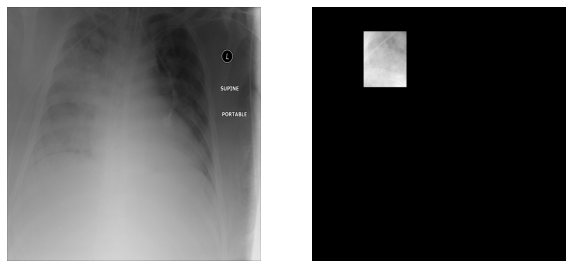

In [30]:
class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

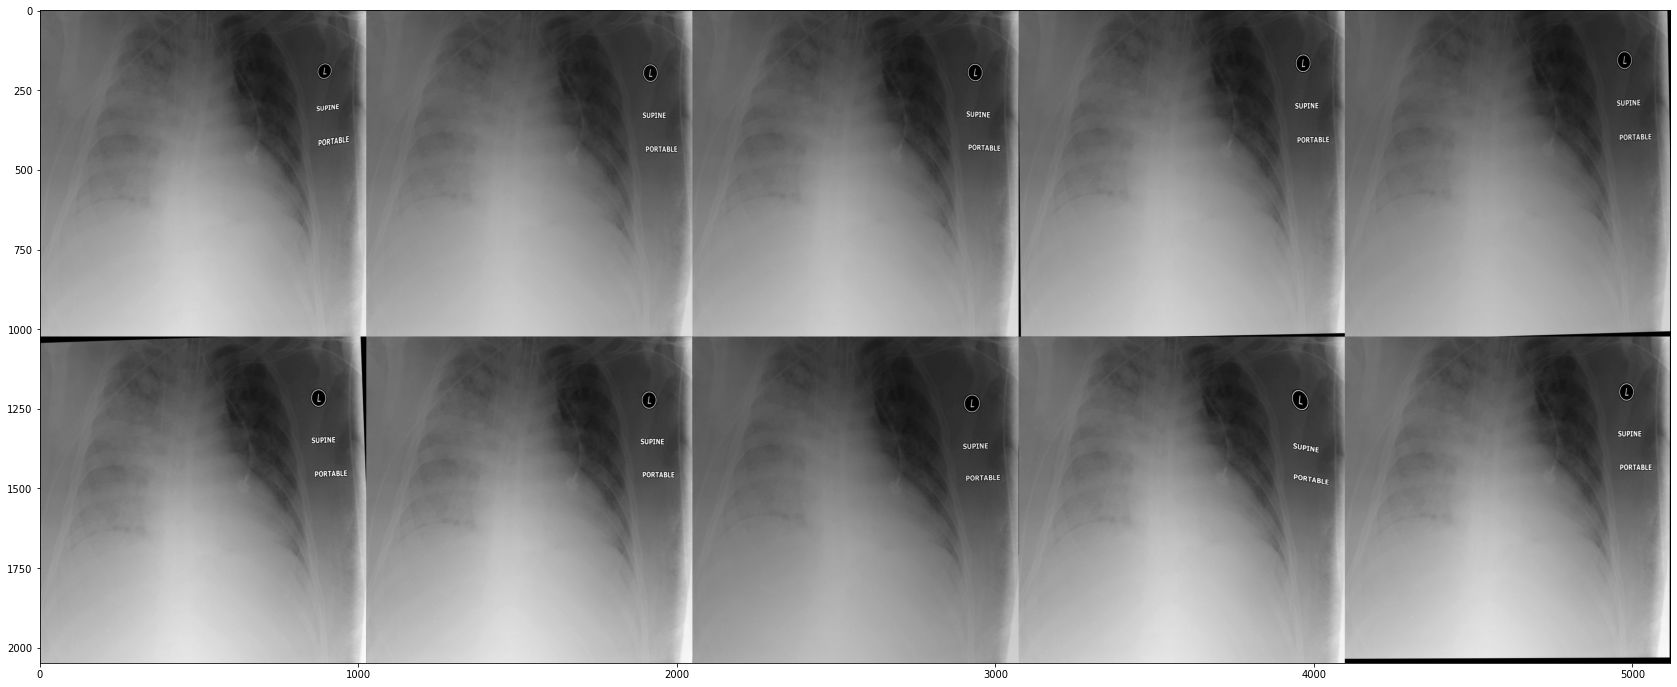

In [31]:
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

In [0]:
os.chdir(PROJ_DIR)

In [33]:
# Training the model using coco h5 file) 
model = modellib.MaskRCNN(mode='training', config=config_tf, model_dir=PROJ_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead







In [0]:
LEARNING_RATE = 0.006

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [35]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=4,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history


Starting at epoch 0. LR=0.012

Checkpoint Path: /content/gdrive/My Drive/Cap-project/pneumonia20200525T1307/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistrib

In [36]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)


,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,2.240064,0.328243,0.698763,0.296394,0.502476,0.414174,2.701074,0.254615,0.937053,0.432259,0.638177,0.438963
2,2.103250,0.224303,0.691047,0.368861,0.467429,0.351559,2.501532,0.263570,0.932862,0.344502,0.549669,0.410896
3,2.158584,0.209407,0.768033,0.315121,0.470655,0.395283,2.156408,0.219963,0.746255,0.323168,0.479755,0.387198
4,2.184635,0.239282,0.751425,0.295713,0.504887,0.393213,2.214791,0.231297,0.828719,0.301847,0.467137,0.385691


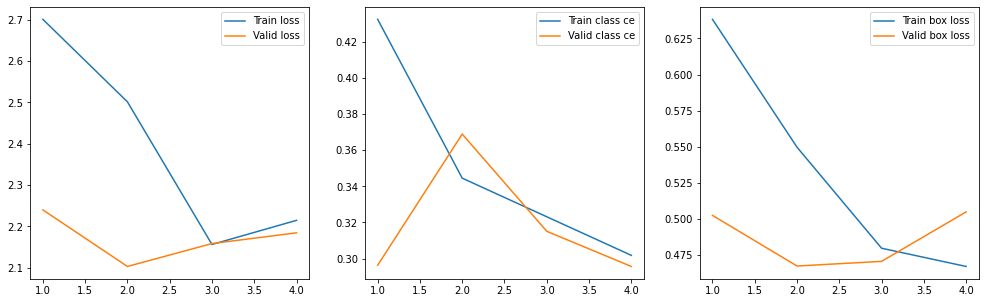

In [37]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [38]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 2 2.1032495641708375


In [39]:
dir_names = next(os.walk(model.model_dir))[1]
key = config_tf.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /content/gdrive/My Drive/Cap-project/pneumonia20200525T1307/mask_rcnn_pneumonia_0001.h5


In [40]:
inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=PROJ_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/gdrive/My Drive/Cap-project/pneumonia20200525T1307/mask_rcnn_pneumonia_0001.h5
Re-starting from epoch 1


In [0]:
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

In [0]:
def dice_coef(y_true, y_pred):
    intersec = y_true*y_pred
    union = y_true+y_pred
    if intersec.sum() == 0:
        dice_coef = 0
    else:
        dice_coef = round(intersec.sum()*2/union.sum(), 2)
    return dice_coef

def coeff_per_image(metric_name, image_id, pred, gt_mask, gt_class_id):
    
    coeff_dict = {}
    
    for clsid in list(inputConfig.CLASS_DICT.keys()):         
        coeff_dict[clsid] = []
        gt_index = np.where(gt_class_id == clsid)
        
        # if there is no groundtruth or no predicted mask, the coefficient is equal to zero
        if gt_index[0].size ==0 or len(pred['masks']) == 0:
            coeff_dict[clsid].append(0)
        else:
            # get the union of all groundtruth masks belong to clsid
            gt_mask_per_class = gt_mask[:,:,gt_index[0]] # get groundtruth mask

            _gt_sum = np.zeros((gt_mask.shape[0],gt_mask.shape[1]))

            for gt_num in range(gt_mask_per_class.shape[2]): # as there may be over one mask per class
                _gt =  gt_mask_per_class[:,:,gt_num]
                _gt_sum = _gt_sum + _gt

            _gt_union = (_gt_sum>0).astype(int)

            # get the union of all predicted masks belong to clsid
            pred_index = np.where(pred['class_ids'] == clsid)
            pred_mask_per_class = pred['masks'][:,:,pred_index[0]]

            _mask_sum = np.zeros((pred['masks'].shape[0],pred['masks'].shape[1]))

            for num in range(pred_mask_per_class.shape[2]):
                _mask = pred_mask_per_class[:,:,num]
                _mask_sum = _mask_sum + _mask

            _mask_union = (_mask_sum>0).astype(int)
            
            if metric_name == 'jaccard index':
                coeff_dict[clsid].append(jaccard_coef(_mask_union, _gt_union))
            elif metric_name == 'dice':
                coeff_dict[clsid].append(dice_coef(_mask_union, _gt_union))
            
    return coeff_dict

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)
(256, 256, 3)

*** No instances to display *** 

{615: {0: [0], 1: [0]}, 1583: {0: [0], 1: [0]}, 1499: {0: [0], 1: [0.73]}, 140: {0: [0], 1: [0]}}
--- 5.130099058151245 seconds ---


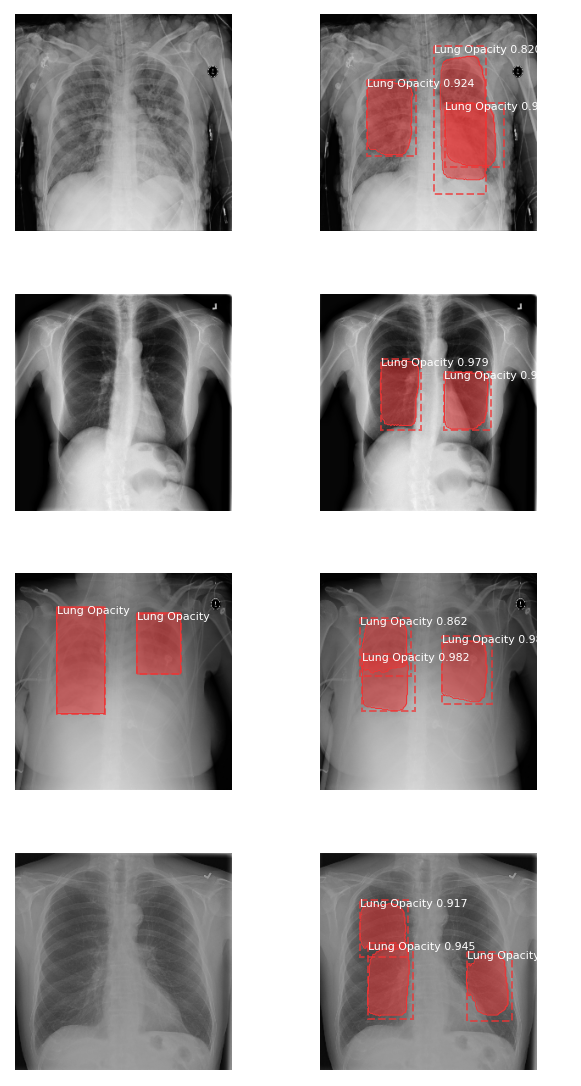

In [43]:
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))
start_time = time.time()
dice_dic = {}
for i in range(4):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    dice_dic[image_id] = coeff_per_image('dice', image_id, r, gt_mask, gt_class_id)
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
print(dice_dic)
print("--- %s seconds ---" % (time.time() - start_time))

In [44]:
image_fps_test_tmp = list(image_fps_val) 

target_0 = 0
target_1 = 0

image_fps_test = list()
for img in image_fps_test_tmp:
  t =image_annotations[img]
  if len(t) > 0:
    image_fps_test.append(img)
  if len (image_fps_test) == 3000:
    break
print ( 'Test list len ' , len(image_fps_test))

def predict_test_frm_tr_tf(image_fps, min_conf=0.98): 

      cm_df_tf = pd.DataFrame(columns = ['patientId', 'y_true', 'y_pred']) 
    
      for image_id in tqdm(image_fps): 

        ds = pydicom.read_file(image_id)
        image = ds.pixel_array
          
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1) 
            
        patient_id = os.path.splitext(os.path.basename(image_id))[0]
        

        results = model.detect([image])
        r = results[0]

        #print ( ' patient_id' , patient_id , ' class' , r['class_ids'] ,  ' score ' , len(r['scores']) )
        #print(' y_true ', image_annotations[image_id][0].patientId , ' class ', image_annotations[image_id][0].Target )
        y_pred = 0
        out_str = ""
        out_str += patient_id 
        assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
        if len(r['rois']) == 0: 
            pass
        else: 
            num_instances = len(r['rois'])
            out_str += ","
            for i in range(num_instances): 
                if r['scores'][i] > min_conf: 
                    
                    out_str += ' '
                    out_str += str(round(r['scores'][i], 2))
                    out_str += ' '

                    # x1, y1, width, height 
                    x1 = r['rois'][i][1]
                    y1 = r['rois'][i][0]
                    width = r['rois'][i][3] - x1 
                    height = r['rois'][i][2] - y1 
                    bboxes_str = "{} {} {} {}".format(x1, y1, \
                                                      width, height)    
                    out_str += bboxes_str
                    y_pred = 1
        
        cm_df_tf = cm_df_tf.append ({'patientId': patient_id, 'y_true' : image_annotations[image_id][0].Target , 'y_pred' : y_pred}, ignore_index=True)

      return cm_df_tf

Test list len  3000


In [45]:
cm_df_tf = predict_test_frm_tr_tf(image_fps_test)
cm_df_tf.head(10)

100%|██████████| 3000/3000 [15:18<00:00,  3.27it/s]


,patientId,y_true,y_pred
0,add544e1-cad8-41ef-8773-ff03258737fc,0,0
1,6000d1b8-1733-4617-93e3-b6a633ea0fce,0,1
2,17af0269-b24a-462b-bb27-01ca17cb6494,0,1
3,0b8d4689-aff3-472b-bad1-d12d648dbc2c,0,0
4,bb1548e0-0d9f-42de-bd43-627c90259a8b,0,0
5,8548b9de-01f8-405e-85a9-8028c8a6e4ac,0,0
6,ad1ab5c2-fe92-498e-b82f-9464f2140c43,0,0
7,ed46b092-fc9f-4caa-ab25-21b5a154fd8d,0,0
8,bce23f47-7e90-48be-ab13-be220200fba0,1,0
9,021443b8-0e56-4ce2-87e2-53302d8441ca,0,0


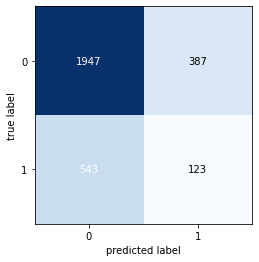

In [46]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_true_tf= cm_df_tf['y_true'].to_list()
y_pred_tf = cm_df_tf['y_pred'].to_list()

CM_tf = confusion_matrix(y_true_tf, y_pred_tf)

fig, ax = plot_confusion_matrix(conf_mat=CM_tf,  figsize=(4, 4))

plt.show()

In [47]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true_tf, y_pred_tf, average='weighted')
print(classification_report(y_true_tf, y_pred_tf))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81      2334
           1       0.24      0.18      0.21       666

    accuracy                           0.69      3000
   macro avg       0.51      0.51      0.51      3000
weighted avg       0.66      0.69      0.67      3000



In [0]:
test_image_fps = get_dicom_fps(test_dicom_dir)

In [0]:
def predict_tf_test(image_fps, filepath='submission1.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE /config_tf.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,pred_string,Pred\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config_tf.IMAGE_MIN_DIM,
                min_scale=config_tf.IMAGE_MIN_SCALE,
                max_dim=config_tf.IMAGE_MAX_DIM,
                mode=config_tf.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]


            out_str = ""
            out_str += patient_id
            #out_str += ","
            y_pred=0
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])
                out_str += ","
                #out_str += str(r['class_ids'][0])
                #out_str += ","
                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str
                        y_pred=1
                if (y_pred ==0 ):
                  out_str += str(0)  
            out_str += ","
            out_str += str(y_pred)
            file.write(out_str+"\n")
            
            

In [50]:
# predict only the first 100 entries
submission_fp = os.path.join(DATA_DIR, 'submission1.csv')
predict_tf_test(test_image_fps[:3000], filepath=submission_fp)
print(submission_fp)

100%|██████████| 3000/3000 [05:48<00:00,  8.61it/s]

/content/gdrive/My Drive/Cap-project/data/submission1.csv


In [51]:
output = pd.read_csv(submission_fp)
output["pred_string"] = output["pred_string"].fillna(0)
output["Pred"] = output["Pred"].fillna(0)
output.head(10)

,patientId,pred_string,Pred
0,1371ec53-f3c3-4c63-8982-cb5a118c6448,0.96 228.0 440.0 244.0 300.0,1
1,1f27caf8-fe15-47cd-915e-18999274bcb3,0.98 164.0 140.0 252.0 560.0 0.97 704.0 412.0...,1
2,23649ef2-dde7-4019-a356-75c7f064dbc5,0.96 336.0 380.0 164.0 448.0,1
3,c010c077-36e0-4e44-ae67-c53d1a5992cc,0,0
4,229ce52f-9e0b-4b6d-abd5-60fc9c3a024a,0.99 184.0 516.0 304.0 248.0 0.97 592.0 428.0...,1
5,0e9709fd-a769-4d60-8a06-29a41c7c8297,0.98 192.0 400.0 156.0 296.0 0.98 580.0 420.0...,1
6,1f0d63fb-3a49-4068-8330-c446f1db22eb,0,0
7,1b90407a-e937-47f8-8cf1-8f801733b78b,0,0
8,1aefa92d-c179-4ced-8006-0df6892abf17,0.97 256.0 428.0 224.0 364.0,1
9,1cba8c35-1b13-45d4-a7dd-9ef2ba5b26df,0.97 652.0 208.0 248.0 248.0,1


14f199ad-e0d2-4360-a186-5aaaa652f3c7
[ 68  68 159 121]
x 272 y 272 h 212 w 364
[ 66 154 143 218]
x 616 y 264 h 256 w 308
23fe0fe9-6021-401d-a981-9c9766bf96b9
[ 94  51 184  98]
x 204 y 376 h 188 w 360
[122 137 180 212]
x 548 y 488 h 300 w 232
[ 56 132 199 184]
x 528 y 224 h 208 w 572
13f6df4f-9b1c-4d25-ba93-f45df7f0e4f6
[ 87 156 159 194]
x 624 y 348 h 152 w 288
[ 62  64 141 123]
x 256 y 248 h 236 w 316
0f7cb40f-fc3b-4778-90db-5becdbd5129f
[102  53 171 114]
x 212 y 408 h 244 w 276
[111 149 183 219]
x 596 y 444 h 280 w 288
[ 50  53 141 107]
x 212 y 200 h 216 w 364


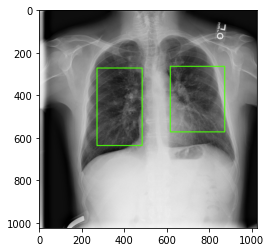

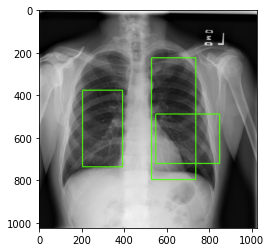

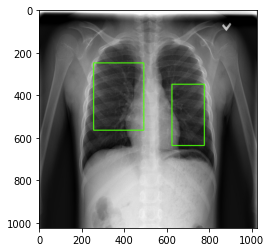

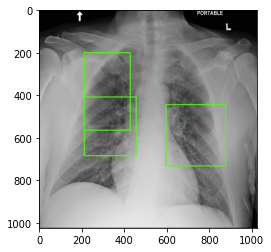

In [52]:
def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config_tf.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config_tf.IMAGE_MIN_DIM,
        min_scale=config_tf.IMAGE_MIN_SCALE,
        max_dim=config_tf.IMAGE_MAX_DIM,
        mode=config_tf.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize()
visualize()
visualize()
visualize()

In [0]:
# Inference 
# Accuracy is good with coco pretained weights and we're able to get 78% accuracy compared to training the full model.
# Accuracy Improves when the Image Size is less compared to 1024X1024